In [1]:
import sys
import argparse
import configparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import cdist
from metadata.const import features, class_label

In [2]:
def get_config(section):
    config = configparser.RawConfigParser()
    config.read('../settings.ini')
    return dict(config.items(section))

In [3]:
def get_box_whisker_range(df):
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    min_range = q1 - 1.5 * iqr
    max_range = q3 + 1.5 * iqr

    return min_range, max_range

In [4]:
def remove_zero_variance(df, features):
    const_filter = VarianceThreshold()
    const_filter.fit(df)
    cols = const_filter.get_support(indices=True)
    return df.iloc[:, cols]

In [5]:
def plot_correlation(correlation, filename, save=True, labels=None):
    fig = plt.figure(figsize=(10.41, 7.29))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlation, vmin=-1, vmax=1)
    fig.colorbar(cax)
    if labels:
        ticks = np.arange(0, len(labels), 1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
                rotation_mode="anchor")
    if save:
        plt.savefig(filename)
    else:
        plt.show()

In [6]:
filename = 'sample-200000.csv'
df = pd.read_csv(f'../dataset/{filename}', dtype={features['similar_http']: str})
df.drop(
    [
        features['unnamed0'],
        features['flow_id'],
        features['source_ip'],
        features['source_port'],
        features['destination_ip'],
        features['destination_port'],
        features['timestamp'],
        features['similar_http'],
    ],
    axis=1,
    inplace=True
)

In [7]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
categorical_features = [features['protocol'], features['inbound']]
numeric_features = [f for f in df.columns
                        if f not in categorical_features]

In [9]:
df.loc[df[class_label] == 'BENIGN', class_label] = 0
df.loc[df[class_label] != 0, class_label] = 1

In [10]:
df = remove_zero_variance(df, numeric_features)

In [11]:
numeric_df = df.drop(categorical_features + [class_label], axis=1)
corr_matrix = numeric_df.corr(method='pearson')

In [12]:
redundent_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            redundent_features.add(corr_matrix.columns[i])

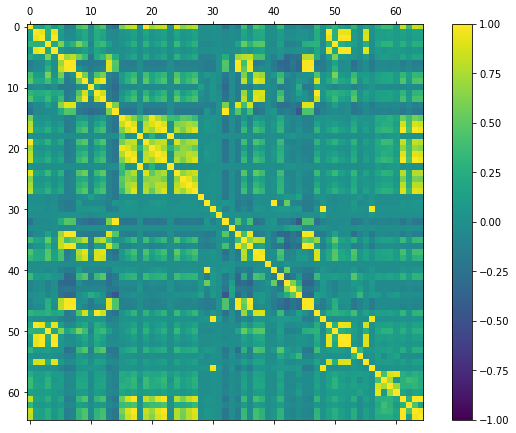

In [13]:
plot_correlation(
    corr_matrix,
    'numeric-correlation.png',
    save=False
#     labels=numeric_df.columns.to_list()
)

In [14]:
df.drop(list(redundent_features), axis=1, inplace=True)

In [15]:
numeric_df = df.drop(categorical_features + [class_label], axis=1)
scale = StandardScaler()
X = scale.fit_transform(numeric_df)
print(X.shape)

(194186, 27)


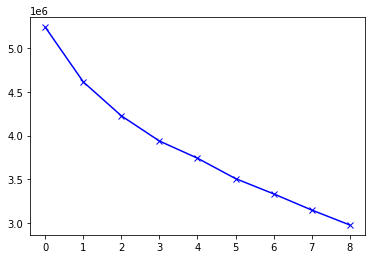

In [16]:
cost = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)
plt.plot(cost, 'bx-')

In [17]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

In [18]:
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(194186, 2)

In [19]:
x, y = X_PCA[:, 0], X_PCA[:, 1]
colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow',
          4: 'orange',
          5: 'purple',
          6: 'pink',
          7: 'gray',
          8: 'brown'}
pca_df = pd.DataFrame({'x': x, 'y': y, 'label': kmeans_labels})
groups = pca_df.groupby('label')

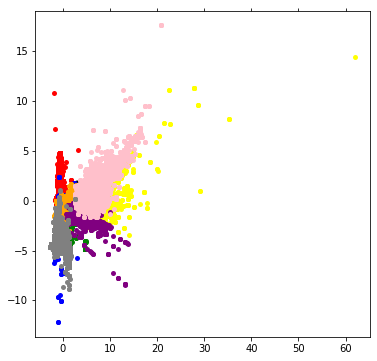

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='black')
plt.show()

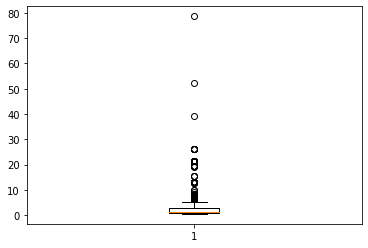

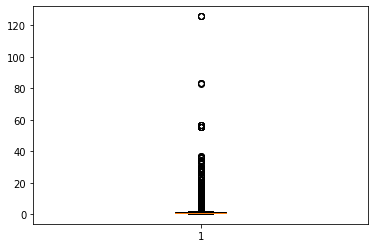

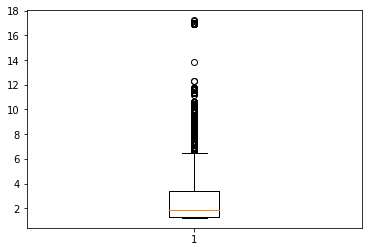

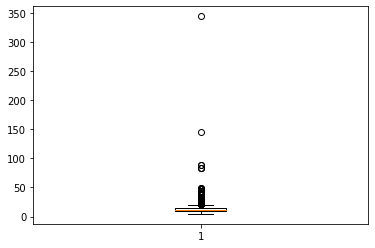

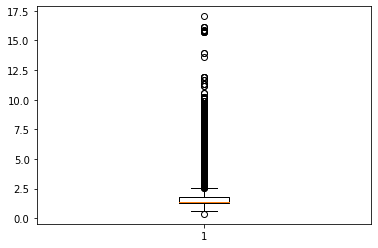

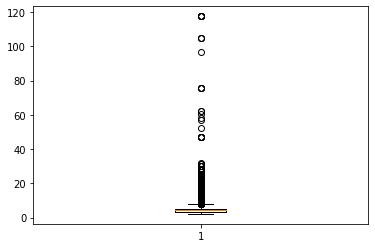

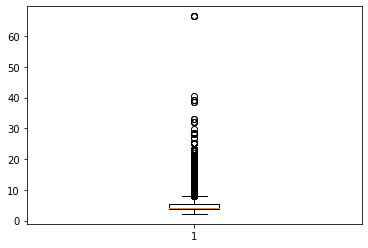

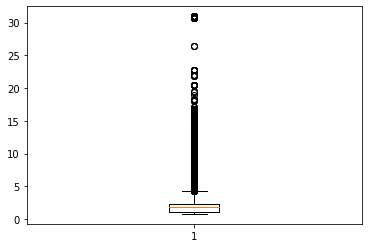

In [21]:
outliers = []
for i, center in enumerate(centroids):
    distances = cdist([center], X[kmeans_labels == i], 'euclidean').ravel()
    truthness = (kmeans_labels == i)
    indices = []
    for j in range(len(truthness)):
        if truthness[j]:
            indices.append(j)
    min_range, max_range = get_box_whisker_range(pd.DataFrame({'distance': pd.Series(distances)}))
    min_range = min_range['distance']
    max_range = max_range['distance']
    for i in range(len(indices)):
        if distances[i] > max_range or distances[i] < min_range:
            outliers.append(indices[i])
    plt.boxplot(distances.tolist())
    plt.show()

In [22]:
print(len(outliers))
df.drop(outliers, axis=0, inplace=True)

17556


In [23]:
df.to_csv(f'clean-{filename}', index=False)